# Data Modelling

In [72]:
#importing libraries 
import pandas as pd
import numpy as np
import json
import pickle
import random

# import sklearn libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC
from  sklearn.model_selection import train_test_split


# import torch deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD


# for reproducability ML
np.random.seed(1)
RandomState=1

# for reproducability of DL
manualSeed = 1
random.seed(manualSeed)
torch.manual_seed(manualSeed)
random.seed(manualSeed)


import warnings
warnings.filterwarnings('ignore')

# Supporting Functions

In [8]:
# #convert feature's string values into numbers to apply models
# label_to_key = {}
# key_to_label = {}
# for i,label in enumerate(sorted(df['Class'].unique())):
#     label_to_key[label] = i
#     key_to_label[i]= label

In [9]:
# load the json to convert from num to lable
with open('Data/processing_models/num_to_label.json') as json_file:
    num_to_label = json.load(json_file)

with open('Data/processing_models/label_to_num.json') as json_file:
    label_to_num = json.load(json_file)

num_to_label,label_to_num

({'0': 'H', '1': 'L', '2': 'M'}, {'H': 0, 'L': 1, 'M': 2})

In [10]:
# to save trained model in pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [11]:
# to load trained model 
def load_pkl_model(path):
    return pickle.load(open(path, 'rb'))
    

**Note**

Since we have less training data instances, so it may be useful to try LOOCV but as we are performing hyper parameter tunning and with some algorithams like Random Forest it will be computaionally very tedious to use LOOCV, so we used k-fold splits as 10 (not 5) in order to get a good balance of low computational cost and low bias

In [12]:
# function using gridsearch cv and StratifiedKFold for the training estimation
# f1 score rather then accuracy
f1 = make_scorer(f1_score, average='micro')
# stratified split
split_count = 10
kf = StratifiedKFold(n_splits=split_count,random_state=RandomState,shuffle=True)
# grid search cv
def get_best_estimator(classifier,grid_param,X,y):
    gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring=f1,
                     cv=kf,
                     n_jobs=-1)

    gd_sr.fit(X, y)
    return gd_sr.best_score_,gd_sr.best_estimator_

In [13]:
# function to drop columns by matching names of columns
def func_dropCol(df,drop_col =['SectionID','StageID','Semester']):
    for i in drop_col:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df

In [14]:
def ohe_converter(train):
    ohe = OneHotEncoder(handle_unknown = 'ignore') 
    encoded_vec = ohe.fit(train)
    ohe_transformed = encoded_vec.transform(train).toarray()
    return ohe_transformed,ohe

In [16]:
# random state for every model for future use
random_state = RandomState

In [17]:
# cv accuracy for each model
acc_wCol = {}
accuracy = {}

# Modelling

## 1. Naive Bays
* **Dataset Passed - Onehot encoded and bxtransformed (Normality)** 

**Assumptions:**

The biggest and only assumption is the assumption of conditional independence.

**Pros:**

1. Gives high performance when the conditional independence assumption is satisfied.
2. Easy to implement because only probabilities need to be calculated.
3. Works well with high-dimensional data, such as text.
4. Fast for real-time predictions.

**Cons:**

1. If conditional independence does not hold, then is performs poorly.
2. Has the problem of Numerical Stability or Numerical Underflow because of the multiplication of several small digits.
 

In [18]:
# loading classifier 
classifier = GaussianNB()

In [116]:
# reading one hot encoded box transformed data 
df = pd.read_csv("Data/transformed/train_bx_ohe.csv")

In [117]:
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,H
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,M
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,L
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,M
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,H


In [118]:
# checking number of rows(r) and columns(c)  (r,c)
df.shape

(408, 61)

In [119]:
# dropping columns with less importance
df = func_dropCol(df)
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,H
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,M
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,M
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,H


In [120]:
# checking number of rows(r) and columns(c) in (r,c) format
df.shape

(408, 56)

In [121]:
# converting Class feature values from str to number
df.Class = df.Class.apply(lambda x :label_to_num[x]) 
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0


In [122]:
# extracting input and target features
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [26]:
# setting range of hyperparameters for grid search

#var_smoothingfloat, default=1e-9
##Portion of the largest variance of all features that is added to variances for calculation stability.
grid_param = {
    'var_smoothing': np.logspace(0,-9, num=10)}

In [27]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)
print(best_score,best_random)

0.6814024390243902 GaussianNB(var_smoothing=0.1)


In [28]:
#acc_wCol['naive_bayes'] = best_score
accuracy['naive_bayes'] = best_score

In [29]:
save_pkl_model("models/naive_bayes.pkl",best_random)

## 2. Decision Trees 

* **Data Passed - Min-Max Normalized and one hot encoded data**

**Assumptions of algorithm** :

1. Initially, whole training data is considered as root.
2. Records are distributed recursively on the basis of the attribute value.

**Pros** :

1. Compared to other algorithms, data preparation requires less time.
2. Doesn’t require data to be normalized.
3. Missing values, to an extent, don’t affect its performance much.
4. Is very intuitive as can be explained as if-else conditions.

**Cons**:

1. Needs a lot of time to train the model.
2. A small change in data can cause a considerably large change in the Decision Tree structure.
3. Comparatively expensive to train.
4. Not good for regression tasks.

https://www.kdnuggets.com/2021/02/machine-learning-assumptions.html 
 

In [30]:
# Data to be used by Decision Tree and Further Algorithams
df = pd.read_csv("Data/transformed/train_mms_ohe.csv")
print("shape " , df.shape)
df = func_dropCol(df)

print("shape after removing columns ", df.shape)
df.Class = df.Class.apply(lambda x :label_to_num[x]) # mapping 
df.head()
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

shape  (408, 61)
shape after removing columns  (408, 56)


In [31]:
classifier = DecisionTreeClassifier(random_state = random_state)

In [32]:
grid_param = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
    'max_features':[2,5,10,20,50]
}

In [33]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)
print(best_score,best_random)

0.720609756097561 DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=50,
                       min_samples_leaf=10, random_state=1)


In [34]:
#acc_wCol['Decision_Tree'] = best_score
accuracy['Decision_Tree'] = best_score

In [35]:
save_pkl_model("models/decision_tree.pkl",best_random)

## 3. Random forest
* **Data Passed - Min-Max Normalized and one hot encoded data**

In [36]:
classifier = RandomForestClassifier(random_state = random_state)

In [55]:
# max features is to consider optimal no. of features in order to manage high variance 
grid_param = {
    'n_estimators': [10,100,500,1000,1500],
    'criterion': ['gini', 'entropy'],
    'max_features':[2,5,10,20,50]
}

In [38]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [39]:
print(best_score,best_random)

0.8112195121951219 RandomForestClassifier(max_features=5, n_estimators=500, random_state=1)


In [40]:
#acc_wCol['Random_forest'] = best_score
accuracy['Random_forest'] = best_score

In [41]:
save_pkl_model("models/random_forest.pkl",best_random)

## 4. Logistic regression 
* **Data Passed - Min-Max Normalized and one hot encoded data**

In [42]:
classifier = LogisticRegression(random_state = random_state)

In [43]:
# l1 penalty is lasso regression (l1 norm regularization)
# l2 penalty is rigid regression (l2 norm regularization)
grid_param =  {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000]
    }

In [44]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

In [45]:
print(best_score,best_random)

0.7620731707317073 LogisticRegression(C=0.3593813663804626, random_state=1)


In [46]:
#acc_wCol['Logistic_regression'] = best_score
accuracy['Logistic_regression'] = best_score

In [47]:
save_pkl_model("models/logistic_regression.pkl",best_random)

## 5. SVM
* **Data Passed - Min-Max Normalized and one hot encoded data**

**Assumptions:**

It assumes data is independent and identically distributed.

**Pros:**

1. Works really well on high dimensional data.
2. Memory efficient.
3. Effective in cases where the number of dimensions is greater than the number of samples.

**Cons:**

1. Not suitable for large datasets.
2. Doesn’t work well when the dataset has noise, i.e., the target classes are overlapping.
3. Slow to train.
4. No probabilistic explanation for classification.

In [48]:
classifier = SVC(random_state = random_state)

In [49]:
grid_param = { 'C':[0.1,1,100,1000],
'kernel':['rbf','poly','sigmoid','linear'],
'degree':[1,5,6]
}

In [50]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [51]:
print(best_score,best_random)

0.7967073170731708 SVC(C=100, degree=1, random_state=1)


In [52]:
#acc_wCol['svm'] = best_score
accuracy['svm'] = best_score

In [53]:
save_pkl_model("models/svm.pkl",best_random)

## 6. XGBOOST
* **Data Passed - Min-Max Normalized and one hot encoded data**
**Assumptions:**

It may have an assumption that encoded integer value for each variable has ordinal relation.

**Pros:**

1. Can work in parallell.
2. Can handle missing values.
3. No need for scaling or normalizing data.
4. Fast to interpret.
5. Great execution speed.

**Cons:**

1. Can easily overfit if parameters are not tuned properly.
2. Hard to tune.

In [54]:
classifier = XGBClassifier()

In [58]:
# grid search cross validation
grid_param  = {
    'n_estimators': [100,500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,5],
    'min_samples_leaf': [2,5,10],
    'max_features':[2,5,20,50]
}

In [59]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

[01:02:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:02:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such

In [60]:
print(best_score,best_random)

0.7398170731707318 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='gini', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_features=2, max_leaves=0, min_child_weight=1,
              min_samples_leaf=2, min_samples_split=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, ...)


In [61]:
#acc_wCol['Xgboost'] = best_score
accuracy['Xgboost'] = best_score

In [62]:
save_pkl_model("models/xgboost.pkl",best_random)

## 7. Neural Network
* **Data Passed - Min-Max Normalized and one hot encoded data**

In [123]:
# not applying K fold cross validation here as the deep learning models take high time and memory to train 
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.15,stratify=y, random_state=RandomState)

In [124]:
# get train and test arrays after converting y to one hot encodding (3 classes)
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values.reshape(-1,1)
y_train,ohe_train = ohe_converter(y_train)
y_test = y_test.values.reshape(-1,1)
y_test = ohe_train.transform(y_test).toarray()

In [125]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [126]:
print(X_train.shape,y_train.shape)

torch.Size([346, 55]) torch.Size([346, 3])


In [127]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

In [128]:
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = 5, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 5, shuffle = False)

In [129]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([5, 55])
Labels batch shape: torch.Size([5, 3])


In [130]:
# train_features.view(1,5,60).shape

In [131]:
# Create ANN Model
# we create a new class ANNModel which inherits from nn.Module 
# define variables in a class and a forward function which uses those variables and perform forward pass 
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 60 --> 32
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        # self.relu1 = nn.ReLU()
        
        # Linear function 2: 32 --> 32
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        # self.tanh2 = nn.Tanh()
        
        # Linear function 3: 32 --> 32
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        # self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 32 --> 1
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = F.relu(self.fc1(x))
        # Non-linearity 1
        # out = self.relu1(out)
        
        # Linear function 2
        out = F.relu(self.fc2(out)) 
        # Non-linearity 2
        # out = self.relu1(out)
        
        # Linear function 2
        out = F.relu(self.fc3(out))
        # Non-linearity 2
        # out = self.relu1(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out
        # return F.softmax(out,dim=1)

In [132]:
# instantiate ANN
input_dim = train_features.size()[1]
hidden_dim = 32 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 3

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)
# to check all working fine, we can simply call model, no need to call specificly forward
# model(train_features)
# model.forward(train_features)

In [133]:
# Cross Entropy Loss as multiClass classification
error = nn.CrossEntropyLoss()

# SGD Optimizer
# model parameters are those variables for which gradient calculation is true, which can be updated
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [134]:
model.parameters

<bound method Module.parameters of ANNModel(
  (fc1): Linear(in_features=55, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)>

In [135]:
EPOCHS = 100

for epoch in range(EPOCHS):
    for data in train_loader:
        # get the batch
        X,y = data
        # make the gradients zero so get ready for next pass else keep getting add
        model.zero_grad()
        output = model(X)

        # depends if our data is one hot encoded 
        # print(output)
        loss =error(output,y)

        # calculate gradient
        loss.backward()

        # update gradient
        optimizer.step()
        print(loss)        

tensor(1.0673, grad_fn=<DivBackward1>)
tensor(0.9903, grad_fn=<DivBackward1>)
tensor(1.0010, grad_fn=<DivBackward1>)
tensor(1.0647, grad_fn=<DivBackward1>)
tensor(1.1495, grad_fn=<DivBackward1>)
tensor(0.9897, grad_fn=<DivBackward1>)
tensor(1.1436, grad_fn=<DivBackward1>)
tensor(1.2233, grad_fn=<DivBackward1>)
tensor(1.0624, grad_fn=<DivBackward1>)
tensor(1.0693, grad_fn=<DivBackward1>)
tensor(0.9837, grad_fn=<DivBackward1>)
tensor(1.1346, grad_fn=<DivBackward1>)
tensor(1.1251, grad_fn=<DivBackward1>)
tensor(1.1349, grad_fn=<DivBackward1>)
tensor(1.0591, grad_fn=<DivBackward1>)
tensor(1.0609, grad_fn=<DivBackward1>)
tensor(1.1417, grad_fn=<DivBackward1>)
tensor(1.0538, grad_fn=<DivBackward1>)
tensor(1.1447, grad_fn=<DivBackward1>)
tensor(1.0013, grad_fn=<DivBackward1>)
tensor(0.9706, grad_fn=<DivBackward1>)
tensor(1.1278, grad_fn=<DivBackward1>)
tensor(1.1522, grad_fn=<DivBackward1>)
tensor(1.1460, grad_fn=<DivBackward1>)
tensor(1.0772, grad_fn=<DivBackward1>)
tensor(1.0733, grad_fn=<D

In [136]:
correct = 0
total = 0
results = []

with torch.no_grad():
    for t_data in test_loader:
        X_t,y_t = t_data
        test_output = model(X_t)
        for idx, i in enumerate(test_output):
            res = torch.argmax(i)
            ohe_res = np.zeros(shape = (1,3))[0]
            ohe_res[res] = 1
            labeled_out = ohe_train.inverse_transform(ohe_res.reshape(1,-1))
            results.append(labeled_out[0][0])    

In [137]:
results = [num_to_label[str(i)] for i in results]

In [138]:
y_tst = [num_to_label[str(i[0])] for i in ohe_train.inverse_transform(y_test)]

In [139]:
from sklearn.metrics import classification_report
report = classification_report(y_tst,results,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
H,0.928571,0.722222,0.812500,18.000000
L,0.727273,0.941176,0.820513,17.000000
M,0.769231,0.740741,0.754717,27.000000
accuracy,0.790323,0.790323,0.790323,0.790323
macro avg,0.808358,0.801380,0.795910,62.000000
weighted avg,0.803986,0.790323,0.789533,62.000000


In [140]:
accuracy['Neural_Network'] = report_df['f1-score']['accuracy']

# Models Comparision

In [141]:
# accuracies when ran without dropping the columns (with all the features, no feature selection )

acc_wCol = {'naive_bayes': 0.6788015657934356,
 'Decision_Tree': 0.7205962059620595,
 'Random_forest': 0.7988557663354412,
 'Logistic_regression': 0.7842818428184282,
 'svm': 0.7842818428184282,
 'Xgboost': 0.720385426076483,
 'Neural_network':0.792683}

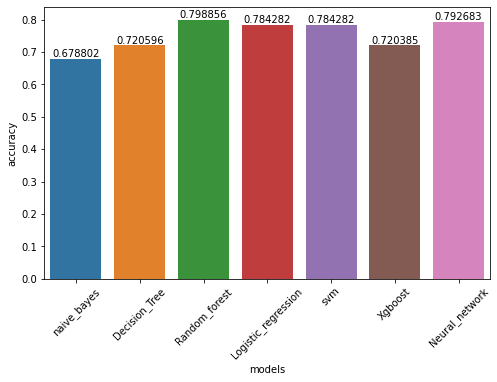

In [142]:
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
acc = pd.DataFrame.from_dict(acc_wCol, orient="index").reset_index()
acc.columns = ['models','accuracy']
ax = sn.barplot(x="models", y="accuracy", data=acc, ax=ax)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', rotation=45)

In [145]:
# accuracies after dropping the columns, 
# saved here so need not to do train the model again 
# {'naive_bayes': 0.6814024390243902,
#  'Decision_Tree': 0.720609756097561,
#  'Random_forest': 0.8112195121951219,
#  'Logistic_regression': 0.7620731707317073,
#  'svm': 0.7967073170731708,
#  'Xgboost': 0.7398170731707318,
#  'Neural_Network': 0.7903225806451613}

In [146]:
accuracy

{'naive_bayes': 0.6814024390243902,
 'Decision_Tree': 0.720609756097561,
 'Random_forest': 0.8112195121951219,
 'Logistic_regression': 0.7620731707317073,
 'svm': 0.7967073170731708,
 'Xgboost': 0.7398170731707318,
 'Neural_Network': 0.7903225806451613}

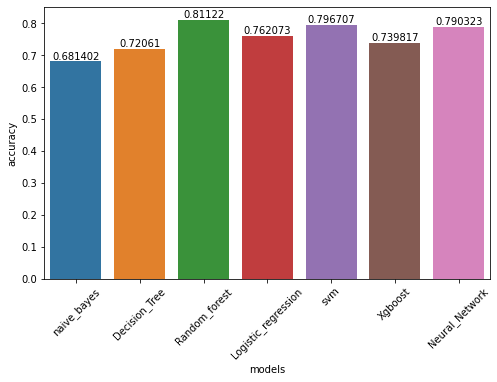

In [147]:
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
acc = pd.DataFrame.from_dict(accuracy, orient="index").reset_index()
acc.columns = ['models','accuracy']
ax = sn.barplot(x="models", y="accuracy", data=acc, ax=ax)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', rotation=45)